In [1]:
TEST = '/kaggle/input/banalyzer-banana-ripeness-classification-dataset/banana_data/data/test'
TRAIN = '/kaggle/input/banalyzer-banana-ripeness-classification-dataset/banana_data/data/train'

We want to use image embeddings for EDA and classification, so let's add some code that will get image embeddings using ResNeXt without fine-tuning.

In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np


DEVICE = torch.device('cpu')
OUTPUT_SIZE = 2048

model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)

extraction_layer = model._modules.get('avgpool')
model.to(DEVICE)
model.eval()

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vec(arg, model, extraction_layer):
    image = normalize(to_tensor(scaler(arg))).unsqueeze(0).to(DEVICE)
    result = torch.zeros(1, OUTPUT_SIZE, 1, 1)
    def copy_data(m, i, o):
        result.copy_(o.data)
    hooked = extraction_layer.register_forward_hook(copy_data)
    with torch.no_grad():
        model(image)
    hooked.remove()
    return result

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 137MB/s]


Let's load up all of our data. This seems like it's going to take forever, but it will be done in less than six minutes.

In [3]:
import arrow
import base64
import pandas as pd
from glob import iglob
from io import BytesIO
from os.path import basename
from os.path import isdir
from PIL import Image

THUMBNAIL_SIZE = (64, 64)

def embed(model, filename: str):
    with Image.open(fp=filename, mode='r') as image:
        return get_vec(arg=image.convert('RGB'), model=model, extraction_layer=extraction_layer).numpy().reshape(OUTPUT_SIZE,)


# https://stackoverflow.com/a/952952
def flatten(arg):
    return [x for xs in arg for x in xs]

def png(filename: str) -> str:
    with Image.open(fp=filename, mode='r') as image:
        buffer = BytesIO()
        # our images are pretty big; let's shrink the hover images to thumbnail size
        image.resize(size=THUMBNAIL_SIZE).convert('RGB').save(buffer, format='png')
        return 'data:image/png;base64,' + base64.b64encode(buffer.getvalue()).decode()

def get_picture_from_glob(arg: str, tag: str,) -> list:
    time_get = arrow.now()
    result = [pd.Series(data=[tag, basename(input_file), embed(model=model, filename=input_file), png(filename=input_file)],
                        index=['tag', 'name', 'value', 'png'] )
        for index, input_file in enumerate(list(iglob(pathname=arg))) ]
    print('encoded {} rows of {}  in {}'.format(len(result), tag, arrow.now() - time_get))
    return result

time_start = arrow.now()
train_dict = {basename(folder) : folder + '/*.*' for folder in iglob(TRAIN + '/*') if isdir(folder)}
train_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, tag=key) for key, value in train_dict.items()]))
test_dict = {basename(folder) : folder + '/*.*' for folder in iglob(TEST + '/*') if isdir(folder)}
test_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, tag=key) for key, value in test_dict.items()]))
print('done in {}'.format(arrow.now() - time_start))

encoded 250 rows of unripe  in 0:01:18.725729
encoded 250 rows of overripe  in 0:01:10.754755
encoded 250 rows of rotten  in 0:01:17.622050
encoded 250 rows of ripe  in 0:01:17.154548
encoded 50 rows of unripe  in 0:00:15.046037
encoded 50 rows of overripe  in 0:00:15.640578
encoded 50 rows of rotten  in 0:00:15.876142
encoded 50 rows of ripe  in 0:00:15.579218
done in 0:06:06.513114


In [4]:
test_df['tag'].value_counts(normalize=True).to_frame().T

tag         unripe  overripe  rotten  ripe
proportion    0.25      0.25    0.25  0.25

Our classes are balanced.

In [5]:
train_df['tag'].value_counts(normalize=True).to_frame().T

tag         unripe  overripe  rotten  ripe
proportion    0.25      0.25    0.25  0.25

Next let's use TSNE to add x/y coordinates based on our image embeddings. We need to do this twice: once for the training data and again for the test data. We need to do this because we can't reuse the training data reducer.

In [6]:
from sklearn.manifold import TSNE

train_reducer = TSNE(random_state=2025, verbose=True, n_jobs=1, perplexity=20.0, init='pca')
train_df[['x', 'y']] = train_reducer.fit_transform(X=train_df['value'].apply(func=pd.Series))
test_reducer = TSNE(random_state=2025, verbose=True, n_jobs=1, perplexity=20.0, init='pca')
test_df[['x', 'y']] = test_reducer.fit_transform(X=test_df['value'].apply(func=pd.Series))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.008s...
[t-SNE] Computed neighbors for 1000 samples in 0.173s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.088832
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.531738
[t-SNE] KL divergence after 1000 iterations: 0.484869
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.001s...
[t-SNE] Computed neighbors for 200 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 1.916026
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.648193
[t-SNE] KL divergence after 1000 iterations: 0.225270


Let's plot.

In [7]:
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool

from bokeh.plotting import figure
from bokeh.plotting import output_notebook
from bokeh.plotting import show
from bokeh.palettes import Turbo256
from bokeh.transform import factor_cmap

output_notebook()

datasource = ColumnDataSource(train_df[['png', 'tag', 'x', 'y']].sample(n=min(len(train_df) - 1, 10000)))
factor_count = max(train_df['tag'].nunique(), 3)
indices = np.linspace(0, len(Turbo256)-1, factor_count, dtype=int)
palette = [Turbo256[index] for index in indices]
mapper = factor_cmap(field_name = 'tag', palette=palette, factors=train_df['tag'].unique().tolist(), start=0, end=factor_count-1, )

plot_figure = figure(title='TSNE projection: bananas', width=1000, height=800, tools=('pan, wheel_zoom, reset'))

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@png' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 18px'>@tag</span>
    </div>
</div>
"""))

plot_figure.scatter(x='x', y='y', source=datasource, line_alpha=0.6, fill_alpha=0.6, size=8, color=mapper)
show(plot_figure)

Loading BokehJS ...

What do we see? It looks like we have some clusters that are essentially duplicates, which probably will inflate our stated model accuracy if we have some of these duplicates in both training and test splits. We also see some cases where the same bananas have been photographed over time, with some images in one class and others in another. See for example the big ripe/overripe cluster in the upper left hand corner of our test data plot. We also see that rotten bananas stand out. Let's build a model and see what happens.

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

logreg = LogisticRegression(max_iter=1000, tol=1e-12).fit(train_df['value'].apply(func=pd.Series), train_df['tag'])
print('model fit in {} iterations'.format(logreg.n_iter_[0]))
print('accuracy: {:5.4f}'.format(accuracy_score(y_true=test_df['tag'], y_pred=logreg.predict(X=test_df['value'].apply(func=pd.Series)))))
print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=test_df['tag'], y_pred=logreg.predict(X=test_df['value'].apply(func=pd.Series)))))
print(classification_report(zero_division=0.0, y_true=test_df['tag'], y_pred=logreg.predict(X=test_df['value'].apply(func=pd.Series))))

model fit in 674 iterations
accuracy: 0.9150
f1: 0.9154
              precision    recall  f1-score   support

    overripe       0.94      0.90      0.92        50
        ripe       0.81      0.92      0.86        50
      rotten       0.96      1.00      0.98        50
      unripe       0.98      0.84      0.90        50

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.92      0.92       200



Our model does pretty well across all classes, with the ripe class being the lowest-accuracy class. Let's take a look at our model probabilities.

<Axes: xlabel='probability', ylabel='Count'>

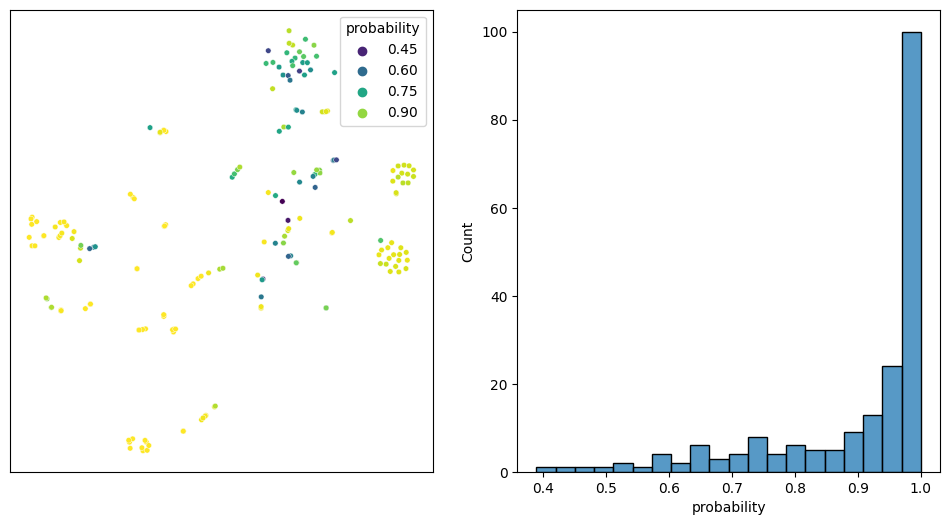

In [9]:
import matplotlib.pyplot as plt
import warnings
from seaborn import histplot
from seaborn import scatterplot

warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')

plot_df = test_df[['x', 'y']].copy()
plot_df['probability'] = np.max(logreg.predict_proba(X=test_df['value'].apply(func=pd.Series)), axis=1)

plt, ax = plt.subplots(ncols=2, figsize=(12, 6))
scatterplot(ax=ax[0], data=plot_df, x='x', y='y', hue='probability', palette='viridis', s=16)
ax[0].set(xlabel=None) 
ax[0].set(ylabel=None)
ax[0].set(xticklabels=[])
ax[0].set(yticklabels=[])
ax[0].tick_params(axis='both', which='both', length=0)
histplot(ax=ax[1], data=plot_df, x='probability', bins=20)

Our test data scatter plot looks different enough from our training data scatter plot that it's hard to tell what classes contribute the most to high/low model probabilities. 